# Import Libraries

In [53]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from tqdm.auto import tqdm 

import re
from nltk.corpus import stopwords 
from collections import Counter 
from string import punctuation 

from sklearn.model_selection import train_test_split 

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional , Dense , LSTM , Embedding , Concatenate , Dropout , TimeDistributed
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
tf.test.is_gpu_available()

True

# Data Preprocessing

In [4]:
df = pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv' , nrows=500000)

In [5]:
def english_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub("[^A-Za-z\s]","",x)) 
    data[col] = data[col].apply(lambda x: x.replace("\s+"," "))
    data[col] = data[col].apply(lambda x: " ".join([word for word in x.split()]))
    return data 

def french_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x : x.lower()) 
    data[col] = data[col].apply(lambda x: re.sub(r'\d','',x))
    data[col] = data[col].apply(lambda x: re.sub(r'\s+',' ',x))
    data[col] = data[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    data[col] = data[col].apply(lambda x: x.strip()) 
    data[col] = "<sos> " + data[col] + " <eos>" 
    return data

In [6]:
df = french_preprocessing(df , 'fr')
df = english_preprocessing(df , 'en')

In [7]:
df["en_len"] = [len(text.split()) for text in df.en]
df['fr_len'] = [len(text.split()) for text in df.fr]

In [8]:
df = df[~(df['en_len'] < 5) & ~(df['en_len'] > 20)]
df = df[~(df['fr_len'] < 5) & ~(df['fr_len'] > 20)]

In [83]:
df.head()

,en,fr,en_len,fr_len
7,the sky of the first inhabitants a contemporar...,<sos> le ciel des premiers habitants la vision...,15,15
12,astronomers introduction introduction video wh...,<sos> astronomes introduction vidéo d'introduc...,7,9
14,the name is derived from the greek root astron...,<sos> son nom vient du grec astron qui veut di...,17,18
18,it prompts us to ask the deepest existential q...,<sos> l'astronomie évoque donc aussi les grand...,9,12
22,the lure of these universal enigmas was the sp...,<sos> l'attrait exercé par ces énigmes univers...,19,18


# Sentence Length Distribution Analysis

In [11]:
px.histogram(df , x = 'en_len' , height = 600 , title = "English Sentences Length Distribution" , marginal="box")

In [12]:
px.histogram(df , x = 'fr_len' , height = 600 , title = "French Sentences Length Distribution" , marginal="box")

# Most Words Used Analysis

In [13]:
def MostWordsUsed(text , n_words) : 
    all_text = ''.join(df[text].values)
    
    words = all_text.split() 
    
    # remove puncs 
    puncs = list(punctuation)
    words = [word for word in words if word not in puncs]
    
    # remove stopwords 
    if text == 'en' : 
        stop_words = set(stopwords.words('english'))
    elif text == 'fr' : 
        stop_words = set(stopwords.words('french'))
        
    words = [word for word in words if not word in stop_words]
    
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(n_words)
    
    return top_words

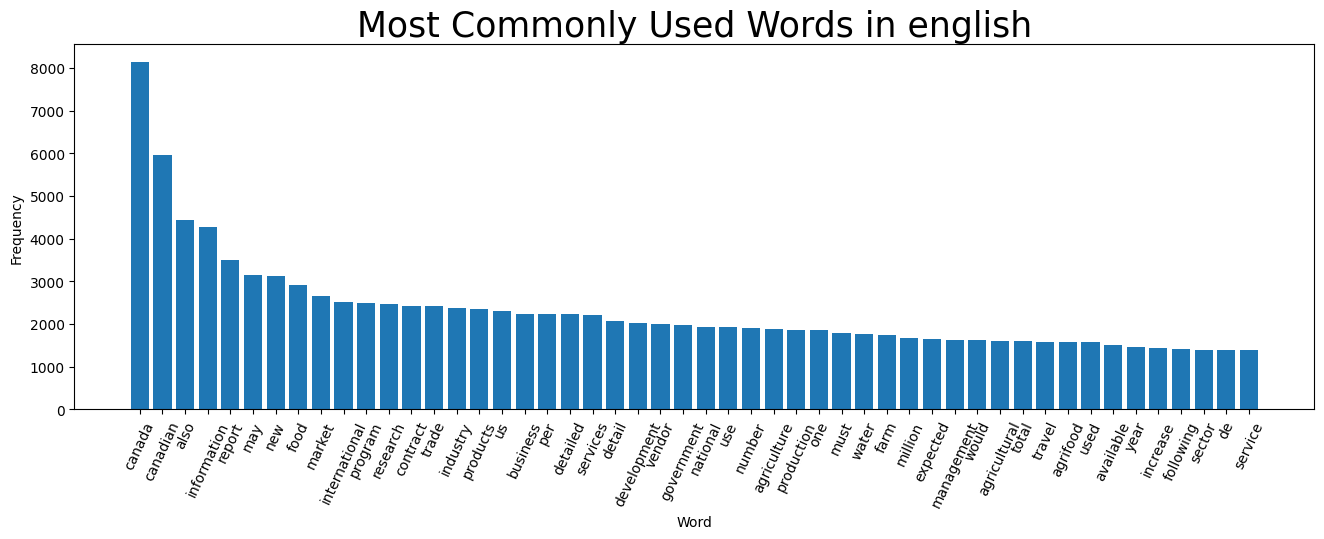

In [14]:
top_en_words = MostWordsUsed('en' , 50)

xaxis = [word[0] for word in top_en_words]
yaxis = [word[1] for word in top_en_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words in english', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

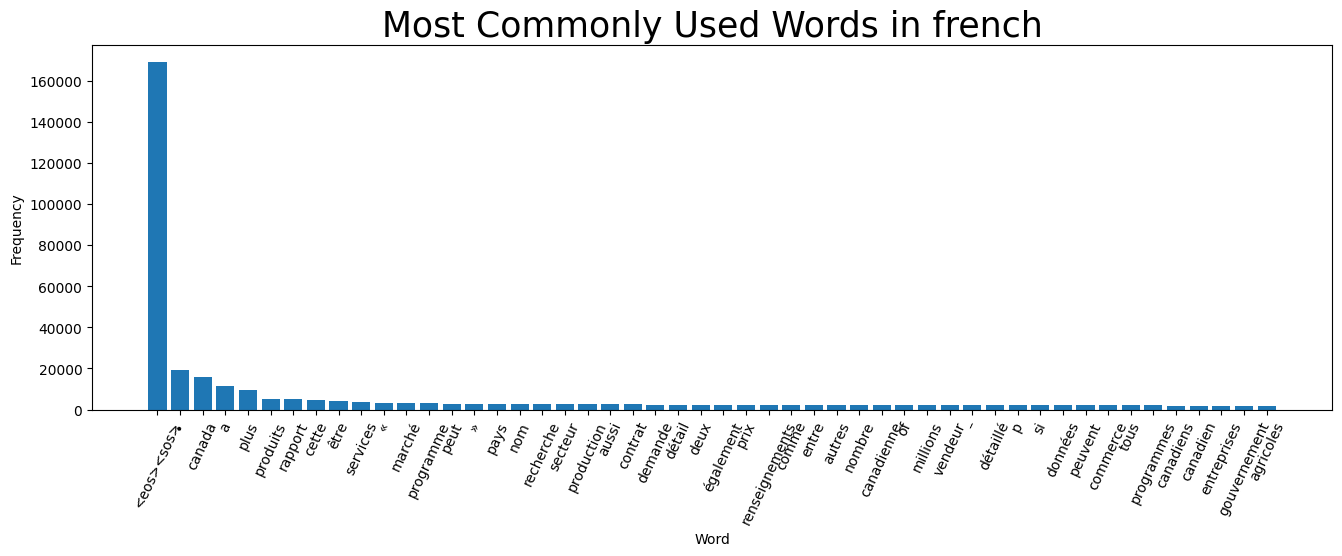

In [15]:
top_fr_words = MostWordsUsed('fr' , 50)

xaxis = [word[0] for word in top_fr_words]
yaxis = [word[1] for word in top_fr_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words in french', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Text to Vector Transformation

In [16]:
def Vectorization(col , MAXLEN = 20) : 
    sents = df[col].tolist() 
    
    # Build vocabulary 
    corpus = [word for text in df[col] for word in text.split()] 
    vocab_size = len(Counter(corpus)) 
    
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" , 
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )
    tokenizer.fit_on_texts(sents) 
    
    tokenizer.word_index['<pad>'] = 0 
    tokenizer.index_word[0] = '<pad>' 
    
    vocab_to_idx = tokenizer.word_index 
    idx_to_vocab = tokenizer.index_word 
    
    # Text Vectorization 
    seqs = tokenizer.texts_to_sequences(sents) 
    
    pad_seqs = pad_sequences(seqs , maxlen = MAXLEN , padding='post')
    
    return vocab_to_idx , idx_to_vocab , pad_seqs , tokenizer

In [17]:
en_vocab , en_inv_vocab , en_seqs , en_tokenizer = Vectorization('en')
fr_vocab , fr_inv_vocab , fr_seqs , fr_tokenizer = Vectorization('fr')

# Split the data

In [18]:
x_train , x_val , y_train , y_val = train_test_split(en_seqs , fr_seqs , train_size = 0.80, random_state = 42)

In [19]:
x_train.shape , x_val.shape

((135318, 20), (33830, 20))

# Data Pipeline

In [20]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

In [21]:
train_set = tf.data.Dataset.from_tensor_slices((x_train , y_train))
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE , drop_remainder = True)

val_set = tf.data.Dataset.from_tensor_slices((x_val , y_val))
val_set = val_set.batch(BATCH_SIZE , drop_remainder = True)

In [22]:
print(f"the size of the training set {len(train_set)} batches of {BATCH_SIZE}")

the size of the training set 1057 batches of 128


In [23]:
print(f"the size of the validation set {len(val_set)} batches of {BATCH_SIZE}")

the size of the validation set 264 batches of 128


# Build our model

In [24]:
# define parameters
EMBEDDING_DIM = 256
SRC_VOCAB_SIZE = len(en_vocab) + 1 # 55126
TRG_VOCAB_SIZE = len(fr_vocab) + 1 # 73164
HIDDEN_DIM = 512
MAXLEN = 20
EPOCHS = 50
LR = 0.001

In [25]:
class Attention(Model) : # Bahdanau Attention
    def __init__(self , hidden_dim) : 
        super(Attention , self).__init__() 
        
        self.W1 = Dense(hidden_dim) 
        self.W2 = Dense(hidden_dim) 
        self.V = Dense(1)
        
    def call(self , s_hidden , h_hidden) : 
        s_hidden = tf.expand_dims(s_hidden , axis = 1) 
        
        score = tf.nn.tanh(self.W1(s_hidden) + self.W2(h_hidden))
        
        attention_weights = tf.nn.softmax(self.V(score) , axis = 1)
        
        context_vector = attention_weights * h_hidden 
        
        context_vector = tf.reduce_sum(context_vector , axis = 1)
        
        context_vector = tf.expand_dims(context_vector , axis = 1)
        
        return context_vector , attention_weights 

In [26]:
class Encoder(Model) : 
    def __init__(self , vocab_size , embedding_dim , hidden_dim) : 
        super(Encoder , self).__init__() 
        
        self.embedding = Embedding(vocab_size , embedding_dim , mask_zero = True)
        self.lstm = Bidirectional(
            LSTM(hidden_dim // 2 , return_sequences=True , return_state= True)
        )
        
    def call(self , x) : 
        embed = self.embedding(x) 
        
        enc_output , forward_h , forward_c , backward_h , backward_c = self.lstm(embed) 
        
        state_h = Concatenate()([forward_h , backward_h]) 
        state_c = Concatenate()([forward_c , backward_c])
        
        return enc_output , state_h , state_c
    
    def summary(self) : 
        x = tf.keras.layers.Input(shape = (None ,))
        model = Model(inputs = [x] , outputs = self.call(x))
        return model.summary()

In [27]:
encoder = Encoder(SRC_VOCAB_SIZE , EMBEDDING_DIM , HIDDEN_DIM)

In [28]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    14112256    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, None, 512),  1050624     ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                 

In [29]:
class Decoder(Model) : 
    def __init__(self , vocab_size , embedding_dim , hidden_dim) : 
        super(Decoder , self).__init__() 
        self.units = hidden_dim 
        
        self.embedding = Embedding(vocab_size , embedding_dim , mask_zero = True) 
        
        self.lstm = LSTM(hidden_dim , return_sequences=True , return_state=True) 
        
        self.attention = Attention(hidden_dim) 
        
        self.fc = TimeDistributed(Dense(vocab_size , activation = 'softmax'))
        
    def call(self , x , enc_output , state_h , state_c) : 
        embed = self.embedding(x)
        
        context_vector , attention_weights = self.attention(state_h , enc_output) 
        
        context_vector = Concatenate(axis = -1)([context_vector , embed]) 
        
        dec_output , dec_h , dec_c = self.lstm(context_vector , initial_state=[state_h , state_c])
        
        output = self.fc(dec_output)
        
        return output , dec_h , dec_c , attention_weights
    
    def summary(self) : 
        x = tf.keras.layers.Input(shape=(None,))
        enc_output = tf.keras.layers.Input(shape=(None, self.units))
        state_h = tf.keras.layers.Input(shape=(self.units,))
        state_c = tf.keras.layers.Input(shape=(self.units,))
        model = Model(inputs=[x, enc_output, state_h, state_c], outputs=self.call(x, enc_output, state_h, state_c))
        return model.summary()

In [30]:
decoder = Decoder(TRG_VOCAB_SIZE , EMBEDDING_DIM , HIDDEN_DIM)

In [31]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 512)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 attention (Attention)          ((None, 1, 512),     525825      ['input_4[0][0]',                
                                 (None, None, 1))                 'input_3[0][0]']          

# Loss and Optimizer

In [32]:
optimizer = Adam(learning_rate=LR)
loss_object = SparseCategoricalCrossentropy() 
# This is done to diminish the output prediction of 0 
# which has no importance and is used only for padding the inputs
def criterion(real , pred) : 
    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(real , 0)) 
    
    # Compute the loss value using the loss object
    loss = loss_object(real , pred) 
    
    # Apply the mask to exclude the padding tokens
    mask = tf.cast(mask , dtype = loss.dtype)
    
    loss *= mask 
    
    loss = tf.reduce_mean(loss)
    
    return loss

# Train our model 

In [33]:
@tf.function 
def train_step(src , trg) : 
    loss = 0 
    with tf.GradientTape() as tape : 
        enc_output , state_h , state_c = encoder(src)
        dec_input = tf.expand_dims(trg[: , 0] , 1)
        
        for i in range(1 , trg.shape[1]) : 
            dec_output , state_h , state_c , _ = decoder(dec_input , enc_output , state_h , state_c)
            
            loss += criterion(trg[: , i] , dec_output[:, 0, :]) 
            
            dec_input = tf.expand_dims(trg[: , i] , 1)
            
    batch_loss = (loss / int(trg.shape[1])) 
    ModelWeights = encoder.trainable_variables + decoder.trainable_variables 
    gradients = tape.gradient(loss , ModelWeights)
    optimizer.apply_gradients(zip(gradients , ModelWeights))
    
    return batch_loss 


@tf.function 
def val_step(src , trg) : 
    loss = 0 
    enc_output , state_h , state_c = encoder(src) 
    dec_input = tf.expand_dims(trg[: , 0] , 1)
    
    for i in range(1 , trg.shape[1]) : 
        dec_output , state_h , state_c , _ = decoder(dec_input , enc_output , state_h , state_c)
        
        loss += criterion(trg[: , i] , dec_output[: , 0 , :])
        
        dec_input = tf.expand_dims(trg[: , i] , 1)
        
    batch_loss = (loss / int(trg.shape[1]))
    
    return batch_loss

In [34]:
with tf.device("/GPU:0") : 
    training_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)) : 
        epoch_loss = [] 
        epoch_val_loss = [] 

        for x_train , y_train in train_set : 
            loss = train_step(x_train , y_train)
            epoch_loss.append(loss)

        for x_val , y_val in val_set : 
            val_loss = val_step(x_val , y_val) 
            epoch_val_loss.append(val_loss) 

        training_losses.append(np.mean(epoch_loss))
        val_losses.append(np.mean(epoch_val_loss))
        if (epoch + 1) % 10 == 0 : 
            print(f"Epoch : {epoch+1} , Training Loss : {training_losses[-1]} , Validation Loss : {val_losses[-1]}\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 10 , Training Loss : 1.0602805614471436 , Validation Loss : 2.3160905838012695

Epoch : 20 , Training Loss : 0.41415101289749146 , Validation Loss : 2.750927686691284

Epoch : 30 , Training Loss : 0.25125449895858765 , Validation Loss : 3.1733505725860596

Epoch : 40 , Training Loss : 0.20947767794132233 , Validation Loss : 3.413120985031128

Epoch : 50 , Training Loss : 0.19500868022441864 , Validation Loss : 3.5563275814056396



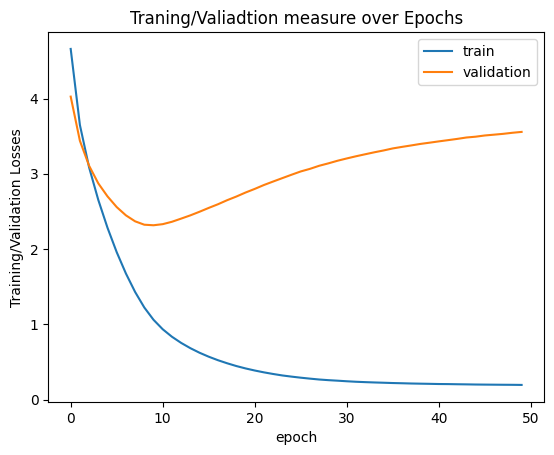

In [35]:
plt.plot(training_losses , label = 'train') 
plt.plot(val_losses , label = 'validation') 
plt.title('Traning/Valiadtion measure over Epochs') 
plt.xlabel('epoch') 
plt.ylabel('Training/Validation Losses') 
plt.legend() 
plt.show()

**so this model has definitely overfit , but we show predictions on test set and focus on the attention scores between the source and target sentences**  

In [36]:
encoder.save_weights('NMT encoder.h5') 
decoder.save_weights('NMT decoder.h5')

# Inference

In [38]:
# load weights 
encoder.load_weights('/kaggle/working/NMT encoder.h5') 
decoder.load_weights('/kaggle/working/NMT decoder.h5')

In [43]:
def predict_sentence(en_input) : 
    eng_seq = en_tokenizer.texts_to_sequences([en_input]) 
    en_input = pad_sequences(eng_seq , maxlen = MAXLEN , padding = 'post') 
    
    hidden_state , next_h , next_c = encoder(en_input) 
    
    attn_plot = [] 
    
    curr_token = np.zeros((1,1)) 
    curr_token[0,0] = fr_tokenizer.word_index['sos'] 
    
    pred_sent = ''
    
    for i in range(MAXLEN) : 
        output , next_h , next_c , attn_w = decoder(curr_token , hidden_state , next_h , next_c)
        
        attn_plot.append(attn_w.numpy().reshape(-1 , )) 
        next_token = np.argmax(output[: , 0 , :] , axis = 1)[0] 
        next_word = fr_tokenizer.index_word[next_token] 
        
        if next_word == 'eos':
            break
        else:
            pred_sent += ' ' + next_word
            curr_token[0,0] = next_token
            
    return pred_sent.strip(), np.array(attn_plot)

In [84]:
test_sample = df.sample(1000)

In [85]:
test_sample = test_sample[~(test_sample['en_len'] < 5) & ~(test_sample['en_len'] > 10)]
test_sample = test_sample[~(test_sample['fr_len'] < 5) & ~(test_sample['fr_len'] > 10)]

In [86]:
x_test = test_sample['en'].tolist() 
y_test = test_sample['fr'].tolist()

# Attention Scores

In [87]:
def plot_attention(attention , sent , pred_sent) : 
    plt.figure(figsize=(9,6))
    plt.rcParams['font.size'] = 7
    g = sns.heatmap(attention, annot=True, fmt='.2f')
    g.set_xticklabels(sent)
    g.set_yticklabels(pred_sent)
    plt.show()

English sentence: issuance of certificates and signing of agreement
Predicted translation: délivrance des certificats et signature de l’entente


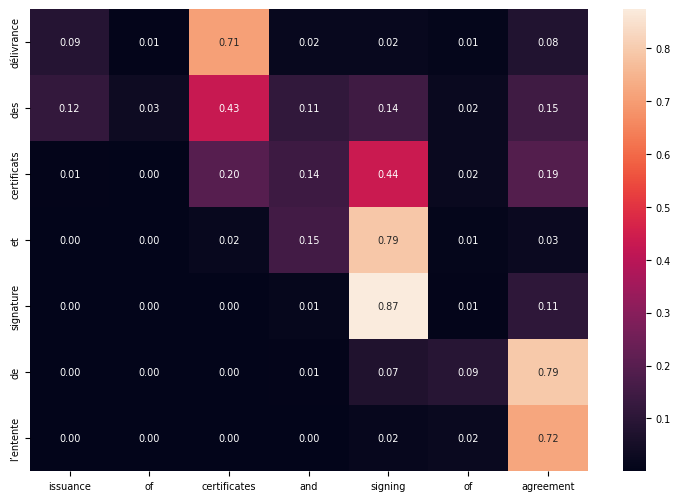

English sentence: table of contents i messages message from the minister
Predicted translation: table des matières i messages message du ministre


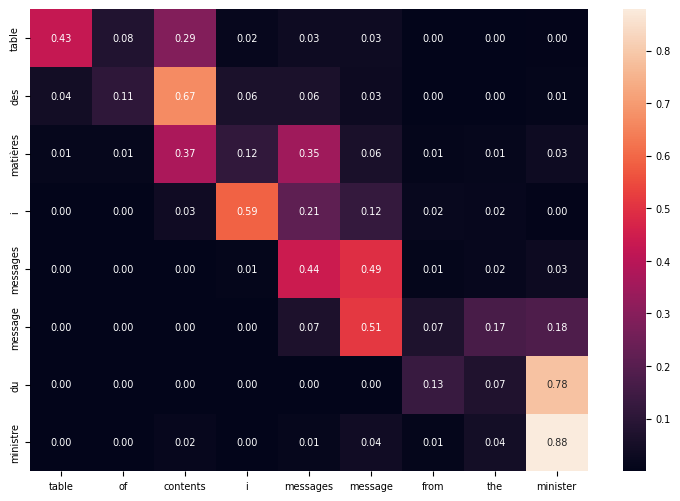

English sentence: combination of factors leads to drop in
Predicted translation: plusieurs facteurs d’exportation ont été calculés à la baisse en


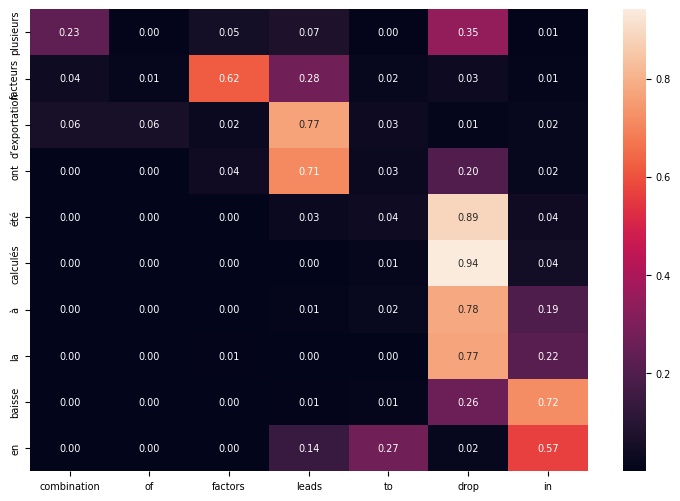

English sentence: canada nigeria at a glance
Predicted translation: coup d'oeil sur nigéria et le canada


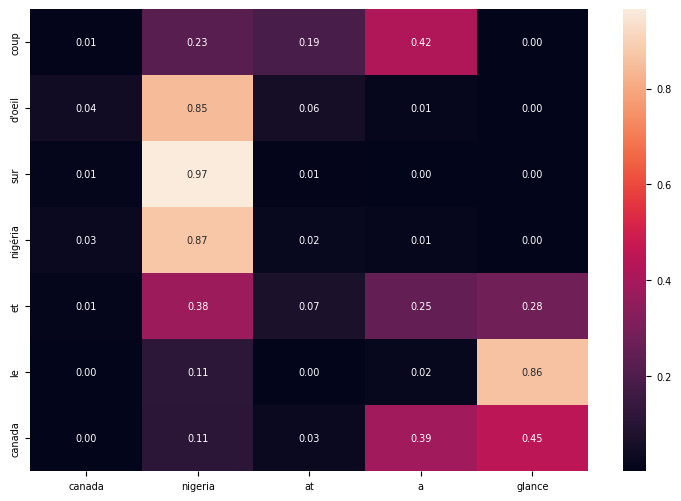

English sentence: micronesia ccg isa imi guam us
Predicted translation: tanzanie républiqueunie de


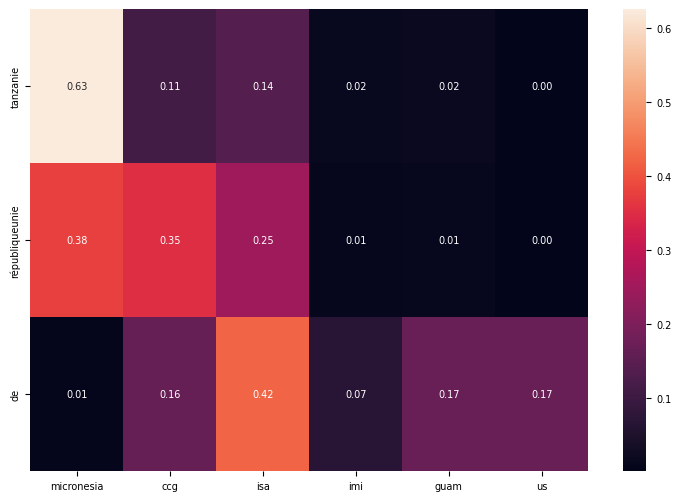

English sentence: downloaded from httpwwwciagovciapublicationsfactbookgeosnlhtml on january
Predicted translation: téléchargé de l'adresse httpwwwtradepartnersgovukbiotechnology netherlandsprofileoverviewshtml le janvier


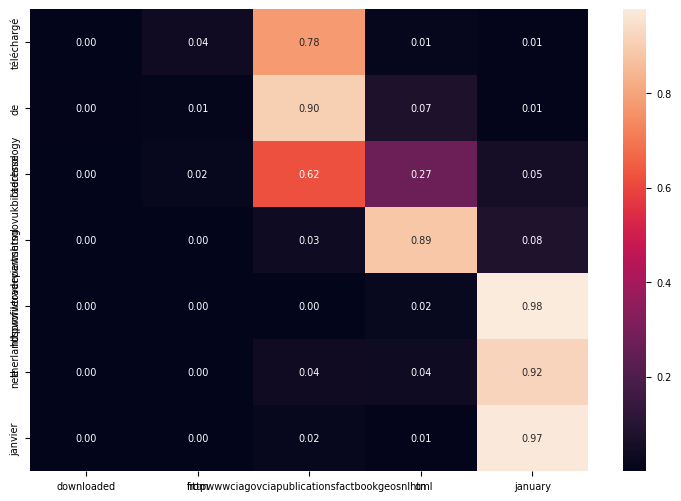

English sentence: government systems for integrated policy is an existing program
Predicted translation: il est difficile d’améliorer les systèmes du programme pour la politique agricole


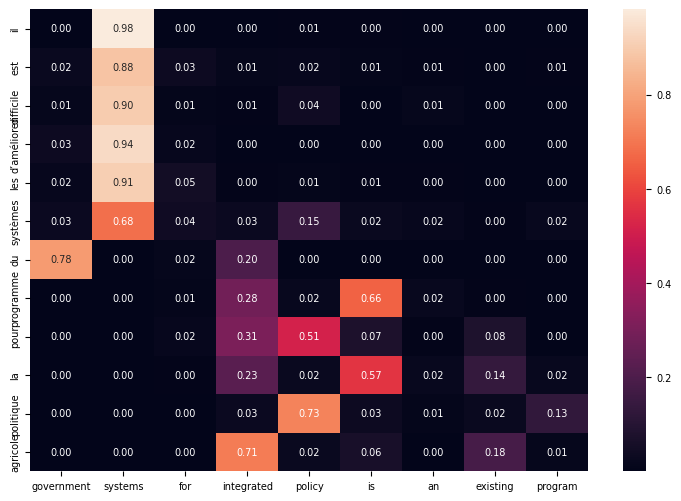

English sentence: reference to other documents in the description
Predicted translation: à la valeur y arriver en partie des documents


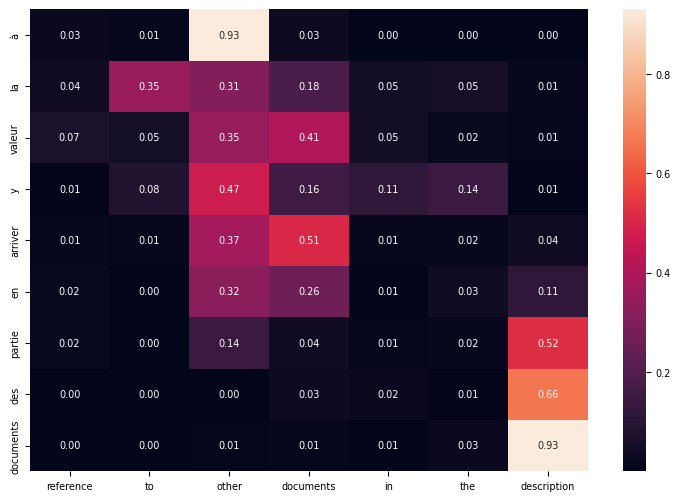

English sentence: treasury board of canada secretariat
Predicted translation: tribunal d'appel des transports du canada haut de la page


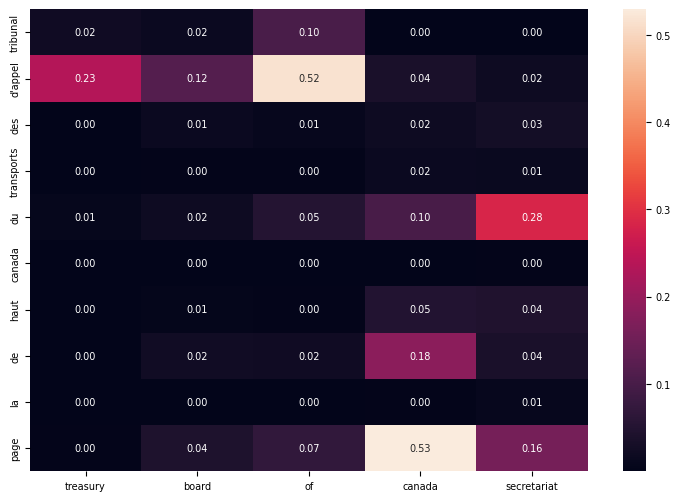

English sentence: i would rather spend my money doing something else
Predicted translation: cela va d'investir près de l'expérience sociale


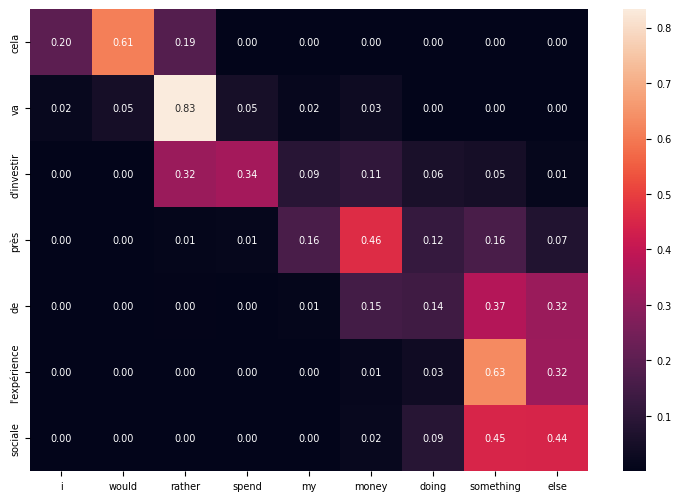

In [88]:
for en_sent in x_test[-10:]:
    result, attention_plot = predict_sentence(en_sent)
    print(f"English sentence: {en_sent}")
    print(f"Predicted translation: {result}")
    attention_plot = attention_plot[:len(result.split()), :len(en_sent.split())]
    plot_attention(attention_plot, en_sent.split(), result.split())